In [2]:
import pandas as pd
# from textblob import TextBlob
import matplotlib.pyplot as plt 
import seaborn as sns
#from googletrans import Translator

# Read Initial DataSet

In [ ]:
# use chunksize to avoi prloblems with big files
twittes = pd.DataFrame(columns=["text","timestamp","likes" , "retweets" ,"replies"])
i=0
chunksize = 10 ** 6
for chunk in pd.read_csv("tweets.csv", chunksize=chunksize  ,sep=';' , engine='python'   ):

    chunk['timestamp']  = pd.to_datetime(chunk['timestamp'] , errors='coerce')

    chunktimp = chunk.loc[ : ,["text","timestamp","likes" , "retweets","replies"] ]
    
    twittes= pd.concat([twittes,chunktimp] ,ignore_index= True)
    i=i+1
    print(i)

In [ ]:
len(twittes)

16890422

Check Nan Values

In [ ]:
print(twittes.isna().sum())
twittes.dropna(inplace=True)
# print(twittes.isna().sum())

# Check twittes is in english or not

In [ ]:
import fasttext
# dowenload model
#wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [ ]:
PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [ ]:
not_en = []
for i in twittes.index:

    if(model.predict(twittes.loc[i,"text"])[0][0].split("__")[-1] !="en"):
       not_en.append(i)

    if i % 10000 == 0:
        print(i)

In [ ]:
len(not_en)

13802716

In [ ]:
twittes.drop(not_en, axis=0, inplace=True)

In [ ]:
twittes.to_csv("EnTwittes.csv")

In [23]:
# def Translate(df):
#     print(df.name)
#     translator = Translator()
#     if(translator.detect(df["text"]) != 'en'):
#         return translator.translate(df["text"], dest='en').text
#     else :
#          return df["text"]


In [1]:
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
# translator = Translator()
# twittes["lan"]= twittes["text"].parallel_apply(lambda s :  translator.detect(s))

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
# twittes["text"]= twittes.apply(lambda row : Translate(row) ,axis=1)

# Clean Text

In [4]:
#Clean Twittes Text
twittes["text"].replace(r'(http|https|ftp)://[a-zA-Z0-9\\./]+','',regex=True, inplace = True)
twittes["text"].replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',regex=True, inplace = True)
twittes["text"].replace("[^a-zA-Z]",' ',regex=True, inplace = True)
twittes["text"].replace(r'\s+',' ',regex=True, inplace = True)
twittes['text'] = twittes['text'].str.lower()

In [5]:
twittes['timestamp'] = pd.to_datetime(twittes['timestamp']).dt.date

In [6]:
print(twittes.isna().sum())
# twittes.dropna(inplace=True)
# print(twittes.isna().sum())

text         0
timestamp    0
likes        0
retweets     0
replies      0
dtype: int64


In [ ]:
#Save the Twiiter DataFrame
# twittes.to_csv("Twittes_Clean.csv")

In [ ]:
twittesCount2 =  twittes.groupby(samples['timestamp'].map(lambda x: x.year))["text"].agg('count').reset_index()
twittesCount2.sort_values(by=['timestamp'] ,ascending = True)

,timestamp,text
0,2016.0,69446
1,2017.0,71088
2,2018.0,72049
3,2019.0,48805


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


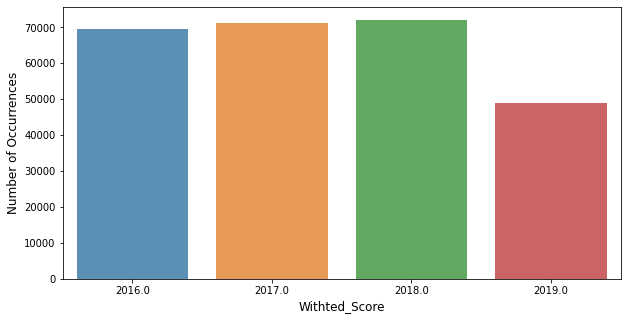

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(twittesCount2["timestamp"], twittesCount2["text"], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Withted_Score', fontsize=12)
plt.show()

# Create weight for each twitte based on number of likes and retweets and replies

In [6]:
twittes['Sum'] = twittes["likes"] + twittes["retweets"] +twittes["replies"]

In [7]:
DaySum =  twittes.groupby(["timestamp"])["Sum"].agg('sum')
DaySum

timestamp
2007-04-19         2.0
2009-01-11       20802
2009-01-21      1991.0
2009-01-27      1363.0
2009-01-29        44.0
                ...   
2019-11-19    198590.0
2019-11-20    199064.0
2019-11-21    326145.0
2019-11-22    205353.0
2019-11-23     42819.0
Name: Sum, Length: 3005, dtype: object

In [8]:
#Calculate the sum avrage for each twitte within the day
#
#
# formula --->  sum(likes + retweets + replies) for i twitte in a day   /   sum(likes + retweets + replies) for all twitte in this day
# but avoid to divid by 0
def Calaulte_Wight (row):
  if( DaySum[row.timestamp] !=0 ):
     result = round(row.Sum / DaySum[row.timestamp],3)
  else :
   result =0
  return result

In [46]:
twittes["weight"] = twittes.apply(Calaulte_Wight , axis=1)

c:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


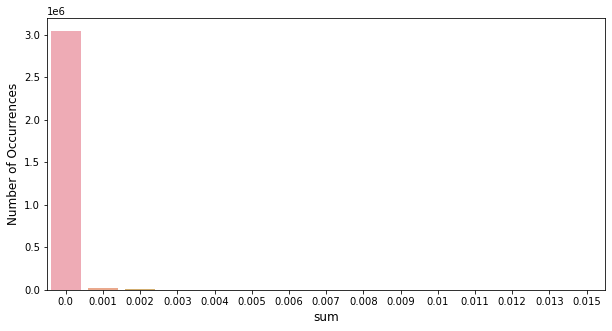

In [47]:
freque_count = twittes['weight'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sum', fontsize=12)
plt.show()

because of so many twittes has wieght == 0 we will assign fixed weight for them because we don't want to lose so many information 

In [48]:
twittes.loc[twittes["weight"] < 0.1  ,"weight"] = 0.1

In [ ]:
#Save the Twiiter DataFrame
twittes.loc[:,["text","timestamp","weight"]].to_csv("CleanTwittes_Wieght.csv")

In [ ]:
# twittes = pd.read_csv("CleanTwittes_Wieght.csv")
# twittes=twittes.drop(["Unnamed: 0"],axis=1)
# twittes['date'] = pd.to_datetime(twittes['date']).dt.date
# twittes

In [ ]:
# twittes['date']
# twittes.sort_values(by='date', ascending=True)
# a= twittes['date'].unique()
# print(sorted(a))
# print(len(twittes['date'].unique()))

# VADER

In [31]:
twittes= pd.read_csv("ReEnTwittes.csv" , index_col=0)
twittes['timestamp'] = pd.to_datetime(twittes['timestamp']).dt.date
twittes.drop(["Unnamed: 0.1"] ,inplace=True , axis=1)
twittes

,text,timestamp,likes,retweets,replies
0,live profit buy b vircurex sell bitfinex bitco...,2016-01-01,0.0,1.0,0.0
1,earn dailly on paypal payza see on bigmoneywix...,2016-01-01,2.0,0.0,0.0
2,in the last mins there were arb opps spanning ...,2016-01-01,0.0,1.0,0.0
3,one bitcoin now worth high low market cap bill...,2016-01-01,0.0,0.0,0.0
4,rdd btc on the exchanges cryptsy bittrex avera...,2016-01-01,0.0,0.0,0.0
...,...,...,...,...,...
265181,,2019-09-08,0.0,0.0,0.0
265182,pog,2019-09-08,0.0,0.0,0.0
265183,lol,2019-09-08,0.0,0.0,0.0
265184,yep,2019-09-09,0.0,0.0,0.0


In [10]:
twittes.loc[265181,"text"]

' '

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

perform VADER method on the text predouce polarity score between [-1 , 1]

In [33]:
SentimentScore = [] 
for text in twittes['text']:
    SentimentScore.append(  [sid_obj.polarity_scores(text)['compound'] , sid_obj.polarity_scores(text)['neg'] ,sid_obj.polarity_scores(text)['neu'] , sid_obj.polarity_scores(text)['pos'] ])
SentimentScore

[[0.4404, 0.0, 0.734, 0.266],
 [0.0, 0.0, 1.0, 0.0],
 [0.4404, 0.0, 0.854, 0.146],
 [-0.0516, 0.14, 0.733, 0.127],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [-0.0516, 0.162, 0.692, 0.146],
 [0.4215, 0.0, 0.781, 0.219],
 [0.0, 0.0, 1.0, 0.0],
 [0.4404, 0.0, 0.854, 0.146],
 [0.4404, 0.0, 0.734, 0.266],
 [0.0, 0.0, 1.0, 0.0],
 [-0.0516, 0.14, 0.733, 0.127],
 [0.0, 0.0, 1.0, 0.0],
 [0.4404, 0.0, 0.734, 0.266],
 [-0.0516, 0.175, 0.667, 0.158],
 [0.4404, 0.0, 0.854, 0.146],
 [0.4404, 0.0, 0.854, 0.146],
 [0.0, 0.0, 1.0, 0.0],
 [-0.0516, 0.15, 0.714, 0.136],
 [0.0, 0.0, 1.0, 0.0],
 [0.7184, 0.0, 0.684, 0.316],
 [0.4404, 0.0, 0.734, 0.266],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.4404, 0.0, 0.854, 0.146],
 [0.4404, 0.0, 0.734, 0.266],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.4404, 0.0, 0.734, 0.266],
 [0.0, 0.0, 1.0, 0.0],
 [0.296, 0.0, 0.738, 0.262],
 [0.4404, 0.0, 0.734, 0.266],
 [0.4404, 0.0, 0.854, 0.146],
 [0.4404, 0.0,

In [34]:
len(SentimentScore)

265186

In [35]:
twittes[["Sentiment_Score","neg",'neu' , "pos"]] = SentimentScore
twittes

,text,timestamp,likes,retweets,replies,Sentiment_Score,neg,neu,pos
0,live profit buy b vircurex sell bitfinex bitco...,2016-01-01,0.0,1.0,0.0,0.4404,0.00,0.734,0.266
1,earn dailly on paypal payza see on bigmoneywix...,2016-01-01,2.0,0.0,0.0,0.0000,0.00,1.000,0.000
2,in the last mins there were arb opps spanning ...,2016-01-01,0.0,1.0,0.0,0.4404,0.00,0.854,0.146
3,one bitcoin now worth high low market cap bill...,2016-01-01,0.0,0.0,0.0,-0.0516,0.14,0.733,0.127
4,rdd btc on the exchanges cryptsy bittrex avera...,2016-01-01,0.0,0.0,0.0,0.0000,0.00,1.000,0.000
...,...,...,...,...,...,...,...,...,...
265181,,2019-09-08,0.0,0.0,0.0,0.0000,0.00,0.000,0.000
265182,pog,2019-09-08,0.0,0.0,0.0,0.0000,0.00,1.000,0.000
265183,lol,2019-09-08,0.0,0.0,0.0,0.4215,0.00,0.000,1.000
265184,yep,2019-09-09,0.0,0.0,0.0,0.2960,0.00,0.000,1.000


c:\Users\mm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


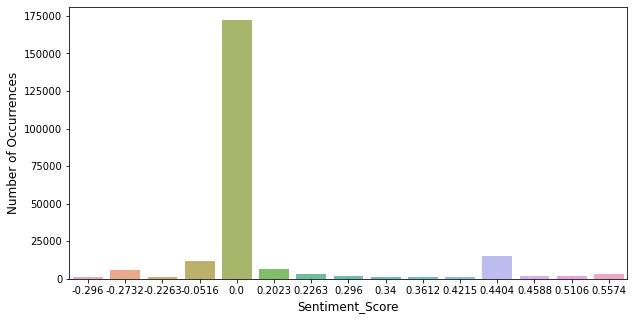

In [18]:
freque_count = twittes['Sentiment_Score'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment_Score', fontsize=12)
plt.show()

In [19]:
# Score_0 = twittes[twittes["Sentiment_Score"]==0]

# roperta

In [ ]:
from scipy.special import softmax
import numpy as np

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification , AutoConfig

tokenizer = AutoTokenizer.from_pretrained("svalabs/twitter-xlm-roberta-bitcoin-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("svalabs/twitter-xlm-roberta-bitcoin-sentiment")

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
samples = pd.read_csv("ReEnTwittes.csv")
samples['timestamp'] = pd.to_datetime(samples['timestamp']).dt.date

In [ ]:
results = []

In [ ]:
import time

In [ ]:
st = time.time()
results = []
for i,text in enumerate(samples.text.tolist()):
    results.append(model(** tokenizer(text , return_tensors="pt")).logits.argmax().item())
    if i % 5000 == 0:
        print(i ,(time.time() - st) )

In [ ]:
samples["Sentiment_Score"] = results
samples.loc[:,["timestamp","Sentiment_Score"]].to_csv("Twittes_rebart_Score_En2.csv")

# Create Withted_Score by multiply score and Wight

In [50]:
twittes["Withted_Score"] = round(twittes["Sentiment_Score"] *  twittes["weight"],3) 

c:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


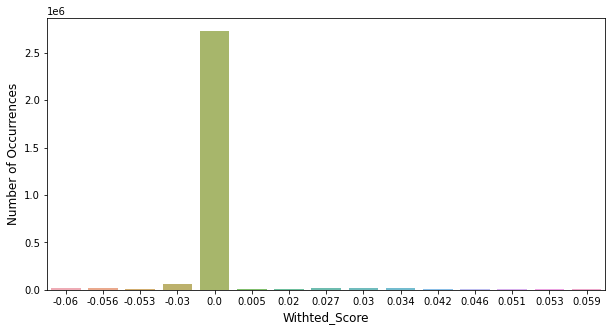

In [51]:
freque_count = twittes['Withted_Score'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Withted_Score', fontsize=12)
plt.show()

In [ ]:
#Save to DataFrame
# twittes.loc[:,["timestamp","weight" ,"Withted_Score","neg",'neu' , "pos" ,"Sentiment_Score"]].to_csv("Twittes_Withted_Score_En2.csv")

# Approch

In [28]:
# twittes = pd.read_csv("Twittes_Withted_Score_En2.csv")
# twittes['timestamp'] = pd.to_datetime(twittes['timestamp']).dt.date

# twittes=twittes.drop(["Unnamed: 0"],axis=1)


In [20]:
def Senti(x):
    if x  >= 0.05:
        return 1 
    elif x <= -0.05:
        return -1
    elif (x > -0.05) and (x < 0.05):
        return 0 

In [21]:
twittes.loc[:,"Sentiment_Score"] = twittes.loc[:,"Sentiment_Score"].apply(lambda x : Senti(x) )

In [36]:
twittes["Sentiment_Score"].value_counts()

 0.0000    172244
 0.4404     14958
-0.0516     11971
 0.2023      6650
-0.2732      5801
            ...  
 0.0145         1
 0.9465         1
 0.9212         1
 0.6771         1
 0.0834         1
Name: Sentiment_Score, Length: 2892, dtype: int64

c:\Users\mm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


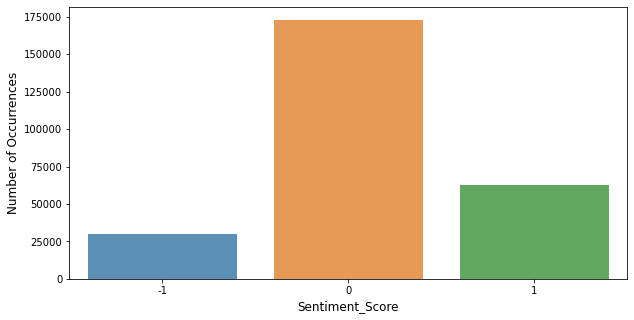

In [23]:
freque_count = twittes['Sentiment_Score'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment_Score', fontsize=12)
plt.show()

In [25]:
twittes.loc[:,["timestamp","Sentiment_Score"]].to_csv("Twittes_Rd.csv")

# Work With Prices

In [25]:
#Read Bitcoin Data
BitCoin_prices =  pd.read_csv("BTC-USD.csv" , parse_dates=["Date"], infer_datetime_format = True)
BitCoin_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800
...,...,...,...,...,...,...,...
2317,2022-07-16,20834.103516,21514.404297,20518.898438,21190.316406,21190.316406,24302954056
2318,2022-07-17,21195.041016,21600.640625,20778.179688,20779.343750,20779.343750,22927802083
2319,2022-07-18,20781.912109,22633.033203,20781.912109,22485.689453,22485.689453,39974475562
2320,2022-07-19,22467.849609,23666.962891,21683.406250,23389.433594,23389.433594,48765202697


In [26]:
#Remove the time from the date
BitCoin_prices['Date'] = pd.to_datetime(BitCoin_prices['Date']).dt.date
BitCoin_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800
...,...,...,...,...,...,...,...
2317,2022-07-16,20834.103516,21514.404297,20518.898438,21190.316406,21190.316406,24302954056
2318,2022-07-17,21195.041016,21600.640625,20778.179688,20779.343750,20779.343750,22927802083
2319,2022-07-18,20781.912109,22633.033203,20781.912109,22485.689453,22485.689453,39974475562
2320,2022-07-19,22467.849609,23666.962891,21683.406250,23389.433594,23389.433594,48765202697


# map Bitcoin With Sentiment score

## Spilit Sentiment_Score tp -1 0 1 columns

In [30]:
sd = pd.get_dummies(twittes, columns=['Sentiment_Score'])
sd

In [32]:
data1 = sd.groupby(["timestamp"])[ "timestamp"].agg('count')
data1

timestamp
2016-01-01    200
2016-01-02    200
2016-01-03    200
2016-01-04    200
2016-01-05    200
             ... 
2019-09-05    200
2019-09-06     69
2019-09-07     21
2019-09-08     13
2019-09-09      2
Name: timestamp, Length: 1348, dtype: int64

In [33]:

data = sd.groupby(["timestamp"])[ "Sentiment_Score_-1", "Sentiment_Score_0","Sentiment_Score_1"].agg('mean')
# data= pd.DataFrame({'date':data.index, 'score':data.values})
data = data.reset_index()
data


C:\Users\mm\AppData\Local\Temp/ipykernel_3824/1155644956.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = sd.groupby(["timestamp"])[ "Sentiment_Score_-1", "Sentiment_Score_0","Sentiment_Score_1"].agg('mean')


,timestamp,Sentiment_Score_-1,Sentiment_Score_0,Sentiment_Score_1
0,2016-01-01,0.120000,0.485000,0.395000
1,2016-01-02,0.040000,0.465000,0.495000
2,2016-01-03,0.015000,0.475000,0.510000
3,2016-01-04,0.020000,0.495000,0.485000
4,2016-01-05,0.015000,0.555000,0.430000
...,...,...,...,...
1343,2019-09-05,0.150000,0.495000,0.355000
1344,2019-09-06,0.028986,0.623188,0.347826
1345,2019-09-07,0.000000,0.571429,0.428571
1346,2019-09-08,0.000000,0.384615,0.615385


In [34]:
data["Count"] =data1.values
data

,timestamp,Sentiment_Score_-1,Sentiment_Score_0,Sentiment_Score_1,Count
0,2016-01-01,0.120000,0.485000,0.395000,200
1,2016-01-02,0.040000,0.465000,0.495000,200
2,2016-01-03,0.015000,0.475000,0.510000,200
3,2016-01-04,0.020000,0.495000,0.485000,200
4,2016-01-05,0.015000,0.555000,0.430000,200
...,...,...,...,...,...
1343,2019-09-05,0.150000,0.495000,0.355000,200
1344,2019-09-06,0.028986,0.623188,0.347826,69
1345,2019-09-07,0.000000,0.571429,0.428571,21
1346,2019-09-08,0.000000,0.384615,0.615385,13


In [35]:
BitCoin_prices.rename(columns = {'Date':'timestamp'}, inplace = True)


In [36]:
Price_Score = BitCoin_prices.merge(data, on=['timestamp'])

In [37]:
Price_Score

,timestamp,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score_-1,Sentiment_Score_0,Sentiment_Score_1,Count
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896,0.030000,0.385000,0.585000,200
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800,0.045000,0.470000,0.485000,200
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400,0.060000,0.545000,0.395000,200
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700,0.025000,0.595000,0.380000,200
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800,0.025000,0.640000,0.335000,200
...,...,...,...,...,...,...,...,...,...,...,...
1272,2019-09-05,10588.183594,10627.269531,10516.417969,10575.533203,10575.533203,14551239508,0.150000,0.495000,0.355000,200
1273,2019-09-06,10578.198242,10898.761719,10292.299805,10353.302734,10353.302734,19536574783,0.028986,0.623188,0.347826,69
1274,2019-09-07,10353.931641,10558.673828,10348.918945,10517.254883,10517.254883,15307366476,0.000000,0.571429,0.428571,21
1275,2019-09-08,10518.114258,10595.637695,10409.090820,10441.276367,10441.276367,13670567493,0.000000,0.384615,0.615385,13


In [38]:
Price_Score.to_csv("Final_Data8.csv")

## Calcaulte count , Variance , Mean

In [12]:
twittes =pd.read_csv("Twittes_Rd.csv",index_col=0)
twittes['timestamp'] = pd.to_datetime(twittes['timestamp']).dt.date

twittes

,timestamp,Sentiment_Score
0,2016-01-01,1
1,2016-01-01,0
2,2016-01-01,1
3,2016-01-01,-1
4,2016-01-01,0
...,...,...
265181,2019-09-08,0
265182,2019-09-08,0
265183,2019-09-08,1
265184,2019-09-09,1


In [13]:
# Rebata Score
Rbarta =pd.read_csv("Twittes_rebart_Score_En2.csv",index_col=0)
Rbarta['timestamp'] = pd.to_datetime(Rbarta['timestamp']).dt.date
Rbarta.rename(columns = {'Sentiment_Score':'Sentiment_Score_Repart',}, inplace = True)

Rbarta["Sentiment_Score_Repart"] = Rbarta["Sentiment_Score_Repart"] - 1
Rbarta

,timestamp,Sentiment_Score_Repart
0,2016-01-01,0
1,2016-01-01,0
2,2016-01-01,0
3,2016-01-01,0
4,2016-01-01,0
...,...,...
265181,2019-09-08,1
265182,2019-09-08,1
265183,2019-09-08,1
265184,2019-09-09,1


c:\Users\mm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


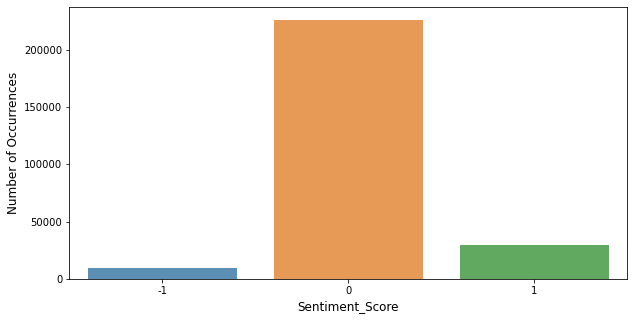

In [14]:
freque_count = Rbarta['Sentiment_Score_Repart'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment_Score', fontsize=12)
plt.show()

In [15]:
twittes["Sentiment_Score_Repart"] = Rbarta["Sentiment_Score_Repart"].values



In [16]:
twittes["Agg_Sentiment_Score_Repart"] =twittes["Sentiment_Score_Repart"]  + twittes["Sentiment_Score"] 
twittes.loc[twittes["Agg_Sentiment_Score_Repart"] ==2,"Agg_Sentiment_Score_Repart"] =1
twittes.loc[twittes["Agg_Sentiment_Score_Repart"] ==-2,"Agg_Sentiment_Score_Repart"] =-1

In [17]:
twittes['Agg_Sentiment_Score_Repart'].value_counts()

 0    154613
 1     79511
-1     31062
Name: Agg_Sentiment_Score_Repart, dtype: int64

In [18]:
twittes

,timestamp,Sentiment_Score,Sentiment_Score_Repart,Agg_Sentiment_Score_Repart
0,2016-01-01,1,0,1
1,2016-01-01,0,0,0
2,2016-01-01,1,0,1
3,2016-01-01,-1,0,-1
4,2016-01-01,0,0,0
...,...,...,...,...
265181,2019-09-08,0,1,1
265182,2019-09-08,0,1,1
265183,2019-09-08,1,1,1
265184,2019-09-09,1,1,1


c:\Users\mm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


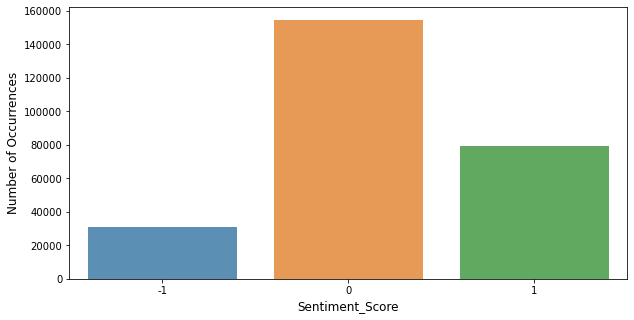

In [19]:
freque_count = twittes['Agg_Sentiment_Score_Repart'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment_Score', fontsize=12)
plt.show()

In [37]:
# data1 = twittes.groupby(["timestamp"])[ "Agg_Sentiment_Score_Repart"].agg(['count','mean','var']).reset_index()
# data1
# data1.fillna(0,inplace=True)
# data1


data1 = twittes.groupby(["timestamp"])[ "Sentiment_Score"].agg(['count','mean','var']).reset_index()
data1
data1.fillna(0,inplace=True)
data1

,timestamp,count,mean,var
0,2016-01-01,200,0.158583,0.060105
1,2016-01-02,200,0.210521,0.052949
2,2016-01-03,200,0.223801,0.052014
3,2016-01-04,200,0.210588,0.052708
4,2016-01-05,200,0.186371,0.049785
...,...,...,...,...
1343,2019-09-05,200,0.122828,0.139555
1344,2019-09-06,69,0.114549,0.043327
1345,2019-09-07,21,0.173300,0.046363
1346,2019-09-08,13,0.211115,0.032638


In [38]:
BitCoin_prices.rename(columns = {'Date':'timestamp'}, inplace = True)


In [39]:
Price_Score = BitCoin_prices.merge(data1, on=['timestamp'])

In [29]:
Price_Score

,timestamp,Open,High,Low,Close,Adj Close,Volume,count,mean,var
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896,200,0.580000,0.315176
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800,200,0.455000,0.339673
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400,200,0.360000,0.352161
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700,200,0.375000,0.285804
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800,200,0.350000,0.278894
...,...,...,...,...,...,...,...,...,...,...
1272,2019-09-05,10588.183594,10627.269531,10516.417969,10575.533203,10575.533203,14551239508,200,0.350000,0.469849
1273,2019-09-06,10578.198242,10898.761719,10292.299805,10353.302734,10353.302734,19536574783,69,0.724638,0.349531
1274,2019-09-07,10353.931641,10558.673828,10348.918945,10517.254883,10517.254883,15307366476,21,0.666667,0.433333
1275,2019-09-08,10518.114258,10595.637695,10409.090820,10441.276367,10441.276367,13670567493,13,1.000000,0.000000


In [41]:
Price_Score["timestamp"]

0       2016-03-12
1       2016-03-13
2       2016-03-14
3       2016-03-15
4       2016-03-16
           ...    
1272    2019-09-05
1273    2019-09-06
1274    2019-09-07
1275    2019-09-08
1276    2019-09-09
Name: timestamp, Length: 1277, dtype: object

In [46]:
# plot Prices
fig = px.line(Price_Score, x="timestamp", y=['mean'], title='Actual Vs Predicted')
fig.show()

In [47]:
# plot Prices
fig = px.line(Price_Score, x="timestamp", y=['Close'], title='Actual Vs Predicted')
fig.show()

In [30]:
# plot Prices
# Initilaize list 
import plotly.express as px 

X = list(Price_Score.loc[:,"timestamp"])
Y = list(Price_Score.loc[:,"Sentiment_Score"])


plot = px.line(x=X, y=Y)

plt.tight_layout()

plot.show()

<Figure size 432x288 with 0 Axes>

In [70]:
Price_Score.to_csv("Final_Data9.csv")

# Scrape

In [5]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
attributes_container = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(Bitcoin OR BTC OR bitcoin ) since:2022-07-21 until:2022-07-22  lang:en').get_items()):
    if i%1000==0:
         print(i)

    attributes_container.append([ tweet.date, tweet.likeCount,tweet.retweetCount,tweet.replyCount, tweet.content])
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(attributes_container, columns=["timestamp", "likes","retweets","replies" ,  "text"])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000


In [8]:
tweets_df.to_csv("Scraped.csv")

In [52]:
tweets_df['Date Created'] = pd.to_datetime(tweets_df['Date Created']).dt.date

print(tweets_df['Date Created'].unique())

[datetime.date(2019, 12, 11) datetime.date(2019, 12, 10)]
